In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/code/phasor_julia`


In [2]:
using PhasorNetworks

[ Info: Precompiling PhasorNetworks [c32d742c-e486-48f1-8804-9f6fb4d3f42c]
  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **



In [3]:
using Plots

[ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
[ Info: Precompiling ZygoteColorsExt [e68c091a-8ea5-5ca7-be4f-380657d4ad79]
[ Info: Precompiling IJuliaExt [2f4121a4-3b3a-5ce6-9c5e-1f2673ce168a]


In [4]:
using LinearAlgebra: triu, diagm, diag

In [5]:
using Statistics: std, median

In [6]:
using QuadGK

In [7]:
using Random: Xoshiro, AbstractRNG

# Construct a random graph

In [8]:
rng = Xoshiro(42)

Xoshiro(0xa379de7eeeb2a4e8, 0x953dccb6b532b3af, 0xf597b8ff8cfd652a, 0xccd7337c571680d1)

In [9]:
function generate_er_graph(n::Int, p::Real, rng::AbstractRNG, self_loops::Bool = false)
    adj = rand(rng, Float64, (n, n)) .< p
    #make undirected
    adj = triu(adj)
    adj =  (adj .+ adj') .> 0

    if !self_loops
        #remove self-loops
        for i in 1:n
            adj[i,i] = 0
        end
    end

    return adj
end

generate_er_graph (generic function with 2 methods)

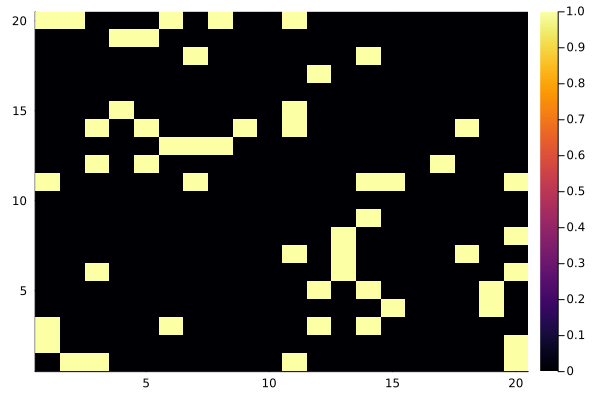

In [11]:
g1 = generate_er_graph(20, 0.1, rng)
heatmap(g1)

# Embed it into an HD vector

In [16]:
function define_node_symbols(graph::AbstractMatrix, nd::Int, rng::AbstractRNG)
    @assert size(graph,1) == size(graph,2) "Takes an adjacency matrix as the input"
    n = size(graph,1)

    #create vectors representing the nodes
    node_values = random_symbols((n, nd), rng)
    return node_values
end

define_node_symbols (generic function with 1 method)

In [17]:
nv1 = define_node_symbols(g1, 1024, rng);

In [18]:
size(nv1)

(20, 1024)

In [19]:
function graph_to_vector(graph::AbstractMatrix, node_values::AbstractMatrix)
    @assert size(graph,1) == size(graph,2) "Takes an adjacency matrix as the input"
    n = size(graph,1)
    nd = size(node_values, 2)

    #get cartesian coordinates representing each edge
    edges = findall(graph)
    n_edges = length(edges)
    edge_values = zeros(Float64, n_edges, nd)

    #iterate through the edges
    for (i, edge) in enumerate(edges)
        tx = edge[1]
        rx = edge[2]

        tx_symbol = node_values[tx,:]
        rx_symbol = node_values[rx,:]
        #create a representation for that edge by binding its incident nodes
        edge_symbol = v_bind(tx_symbol, rx_symbol)
        edge_values[i,:] = edge_symbol
    end

    #combine the edges in the graph to the single embedding via bundling
    graph_embedding = v_bundle(edge_values, dims=1)
    return graph_embedding
end

graph_to_vector (generic function with 2 methods)

In [20]:
gv1 = graph_to_vector(g1, nv1)

1×1024 Matrix{Float64}:
 0.382364  0.334086  -0.66299  -0.463187  …  -0.17652  -0.584388  0.675273

In [21]:
sa = SpikingArgs(threshold=0.0001)

Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.0001 (V)


In [24]:
function graph_to_vector(graph::AbstractMatrix, node_values::AbstractMatrix, spk_args::SpikingArgs; repeats::Int=5)
    @assert size(graph,1) == size(graph,2) "Takes an adjacency matrix as the input"
    n = size(graph,1)
    nd = size(node_values, 2)
    
    #slice each node symbol into a spike train
    train_values = [phase_to_train(reshape(node, (1,:)), spk_args, repeats=repeats) for node in eachslice(node_values, dims=1)]
    tspan = (0.0, repeats * 1.0)
    
    #get cartesian coordinates representing each edge
    edges = findall(graph)
    n_edges = length(edges)
    edge_values = []

    #iterate through the edges
    function edge_to_train(edge)
        tx = edge[1]
        rx = edge[2]

        tx_symbol = train_values[tx]
        rx_symbol = train_values[rx]
        #create a representation for that edge by binding its incident nodes
        edge_symbol = v_bind(tx_symbol, rx_symbol, spk_args=spk_args, tspan=tspan)
        return edge_symbol
    end

    edge_values = map(edge_to_train, edges)
    #combine the edges in the graph to the single embedding via bundling
    combined = vcat_trains(edge_values)
    graph_embedding = v_bundle(combined, dims=1, spk_args=spk_args, tspan=tspan)
    return train_values, graph_embedding, tspan
end

graph_to_vector (generic function with 2 methods)

In [25]:
nvt1, gvt1, tspan = graph_to_vector(g1, nv1, sa, repeats=5)

(SpikeTrain[Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes.], Spike Train: (1, 1024) with 1554 spikes., (0.0, 5.0))

In [26]:
c = graph_to_vector(g1, nv1, sa, repeats=5)

(SpikeTrain[Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes., Spike Train: (1, 1024) with 5120 spikes.], Spike Train: (1, 1024) with 1554 spikes., (0.0, 5.0))

In [27]:
pc = train_to_phase(, sa);

LoadError: MethodError: no method matching train_to_phase(::Tuple{Vector{SpikeTrain}, SpikeTrain, Tuple{Float64, Float64}}, ::SpikingArgs)

[0mClosest candidates are:
[0m  train_to_phase([91m::SpikeTrain[39m, ::SpikingArgs)
[0m[90m   @[39m [36mPhasorNetworks[39m [90m~/.julia/packages/PhasorNetworks/aUVbH/src/[39m[90m[4mspiking.jl:394[24m[39m


In [28]:
pc[4,:,:]

LoadError: UndefVarError: `pc` not defined

In [29]:
phases = train_to_phase(gvt1, sa);

In [30]:
size(phases)

(6, 1, 1024)

In [31]:
ss = similarity(gv1, zero_nans(phases[end-1,1:1,:]), dim=1)

1×1024 Matrix{Float64}:
 -0.842892  -0.901022  0.922641  …  -0.00831339  0.982932  -0.832075

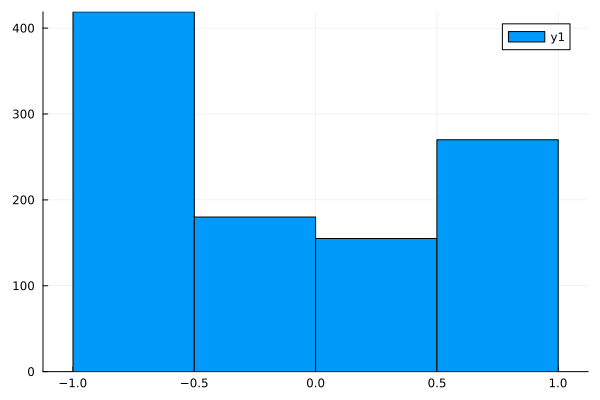

In [32]:
histogram(ss |> vec)

In [26]:
median(ss)

-0.06651201159604642

# Use similarity to reconstruct the graph

In [23]:
function query_edges(graph::AbstractMatrix, nodes::AbstractMatrix)
    n = size(nodes, 1)
    nd = size(graph, 2)

    adj_rec = zeros(Float64, n, n)
    for (i,node) in enumerate(eachslice(nodes, dims=1))
        #add a dimension for consistency
        node = reshape(node, (1, :))
        query = unbind(graph, node)
        s = similarity_outer(query, nodes, dims=1) |> vec
        adj_rec[i,:] = s
    end

    return adj_rec
end

query_edges (generic function with 1 method)

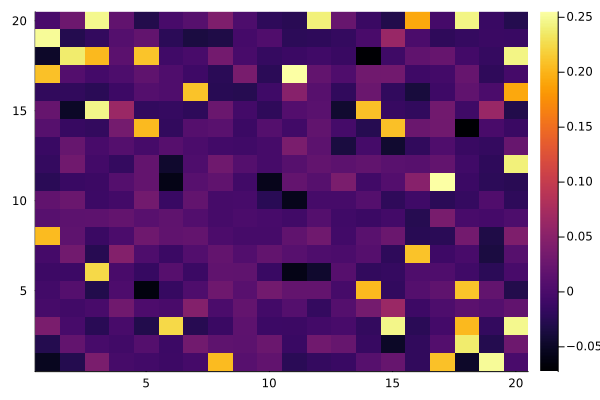

In [24]:
rec1 = query_edges(gv1, nv1)
heatmap(rec1)

In [25]:
function query_edges(graph::SpikeTrain, nodes::Vector{<:SpikeTrain}, spk_args::SpikingArgs, tspan::Tuple{<:Real, <:Real})
    all_nodes = vcat_trains(nodes)
    
    function query_edge(node)
        query = unbind(graph, node, tspan=tspan, spk_args=spk_args)
        s = similarity_outer(query, all_nodes, dims=1, reduce_dim=2, spk_args=sa, tspan=tspan)
        return s
    end
    
    similarity = map(query_edge, nodes)
    adj_rec = stack(map(x -> last.(x), similarity))[1,:,:]

    return adj_rec
end

query_edges (generic function with 2 methods)

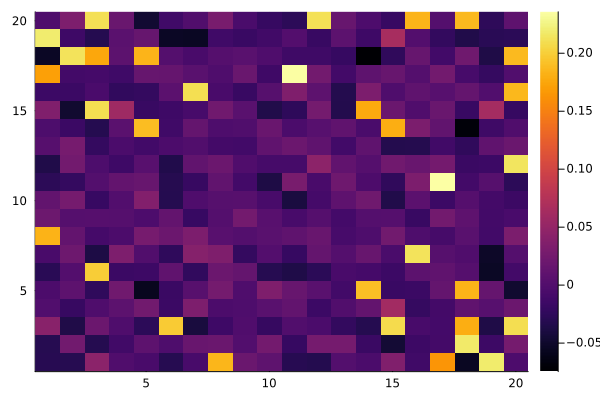

In [26]:
rec2 = query_edges(gvt1, nvt1, sa, tspan)
heatmap(rec2)

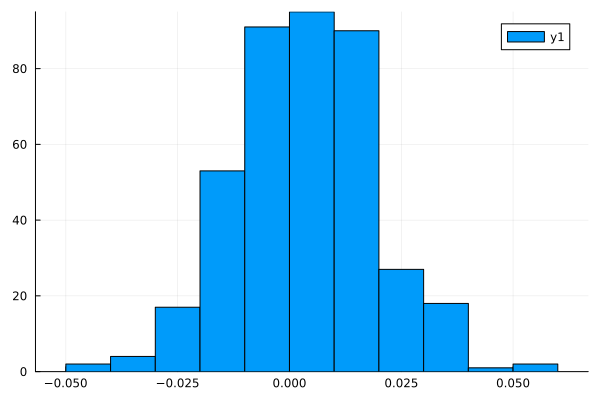

In [27]:
histogram((rec1 .- rec2)|> vec)

# Determine the quality of the reconstruction (AUROC)

In [28]:
function auroc(graph::AbstractMatrix, reconstruction::AbstractMatrix)
    tpr, fpr = tpr_fpr(vec(reconstruction), vec(graph))
    roc_fn = interpolate_roc((tpr, fpr))
    auc, err = quadgk(x -> roc_fn(x), 0.0, 1.0)
    return auc, err
end

auroc (generic function with 1 method)

In [29]:
auroc(g1, rec1)

┌ Warning: Duplicated knots were deduplicated. Use Interpolations.deduplicate_knots!(knots) explicitly to avoid this warning.
│   k1 =
│    403-element Vector{Float64}:
│     0.0
│     0.0
│     0.0
│     0.0
│     0.0
│     ⋮
│     1.0
│     1.0
│     1.0
│     1.0
│     1.0
└ @ Interpolations ~/.julia/packages/Interpolations/nDwIa/src/gridded/gridded.jl:77


(1.0, 0.0)

In [30]:
auroc(g1, rec2)

┌ Warning: Duplicated knots were deduplicated. Use Interpolations.deduplicate_knots!(knots) explicitly to avoid this warning.
│   k1 =
│    403-element Vector{Float64}:
│     0.0
│     0.0
│     0.0
│     0.0
│     0.0
│     ⋮
│     1.0
│     1.0
│     1.0
│     1.0
│     1.0
└ @ Interpolations ~/.julia/packages/Interpolations/nDwIa/src/gridded/gridded.jl:77


(1.0, 0.0)

In [31]:
auroc(g1, rand(rng, Float32, size(rec2)))

┌ Warning: Duplicated knots were deduplicated. Use Interpolations.deduplicate_knots!(knots) explicitly to avoid this warning.
│   k1 =
│    403-element Vector{Float64}:
│     0.0
│     0.06793478260869565
│     0.16032608695652173
│     0.2391304347826087
│     0.32608695652173914
│     ⋮
│     1.0
│     1.0
│     1.0
│     1.0
│     1.0
└ @ Interpolations ~/.julia/packages/Interpolations/nDwIa/src/gridded/gridded.jl:77


(0.575959582829452, 7.920927685728819e-9)

In [32]:
tpr, fpr = tpr_fpr(vec(rec1), vec(g1))

([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

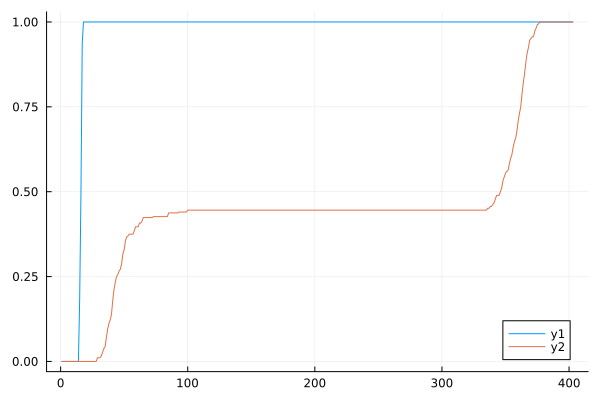

In [33]:
plot(tpr)
plot!(fpr)

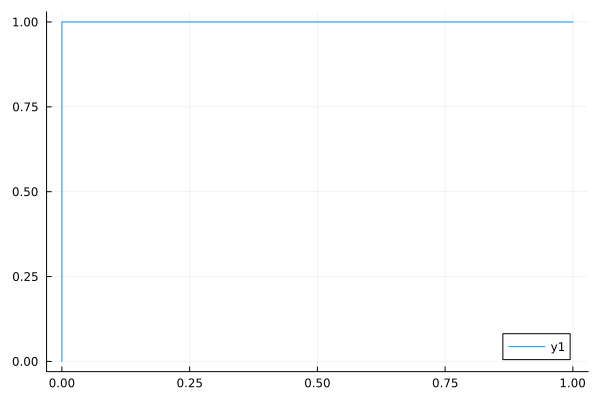

In [34]:
plot(fpr, tpr)

In [35]:
roc = interpolate_roc((tpr, fpr));

┌ Warning: Duplicated knots were deduplicated. Use Interpolations.deduplicate_knots!(knots) explicitly to avoid this warning.
│   k1 =
│    403-element Vector{Float64}:
│     0.0
│     0.0
│     0.0
│     0.0
│     0.0
│     ⋮
│     1.0
│     1.0
│     1.0
│     1.0
│     1.0
└ @ Interpolations ~/.julia/packages/Interpolations/nDwIa/src/gridded/gridded.jl:77


In [36]:
quadgk(x -> roc(x), 0.0, 1.0)

(1.0, 0.0)

In [37]:
tpr2, fpr2 = tpr_fpr(vec(rec2), vec(g1))

([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])

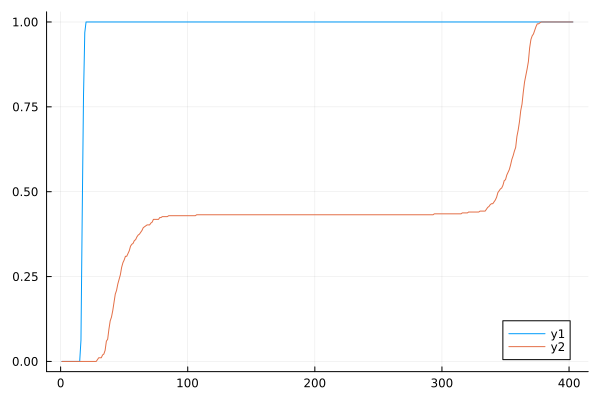

In [38]:
plot(tpr2)
plot!(fpr2)

In [39]:
quadgk(x -> interpolate_roc((tpr2, fpr2))(x), 0.0, 1.0)

┌ Warning: Duplicated knots were deduplicated. Use Interpolations.deduplicate_knots!(knots) explicitly to avoid this warning.
│   k1 =
│    403-element Vector{Float64}:
│     0.0
│     0.0
│     0.0
│     0.0
│     0.0
│     ⋮
│     1.0
│     1.0
│     1.0
│     1.0
│     1.0
└ @ Interpolations ~/.julia/packages/Interpolations/nDwIa/src/gridded/gridded.jl:77


(1.0, 0.0)